# 汽车边缘识别
    1.随机取汽车图片上的一小块patch,凡是取到了一个像素的汽车,就作为正例数据集,car
    2.随机取汽车图片上的一小块patch,凡是取到了非汽车区域,就作为负例数据集,noncar
    3.标注数据不仅仅是0和1,还需要训练汽车的边缘特征

In [1]:
import os
import os.path
from os import walk
from os.path import join
import numpy as np

base_path = '/home/workspace/kaggle/download_files/'

def get_picture(path):
    path0 = join(base_path + path)
    picture = []
    for _,_,filenames in walk(path0):
        for filename in filenames:
            file_prefix = os.path.splitext(filename)[0]
            if os.path.exists(join(path0, file_prefix + ".jpg")):
                picture.append(filename)
            elif os.path.exists(join(path0, file_prefix + ".gif")):
                picture.append(filename)
            else:
                print("路径不对或者没有这种格式的文件")
    return picture

In [2]:
car_pictures = get_picture("train")

mask_pictures = get_picture("train_masks")

len(car_pictures), len(mask_pictures)

(5088, 5088)

In [3]:
train_set = car_pictures[0:3801]
valid_set = car_pictures[3801:5068]
test_set = car_pictures[5068:5088]
len(train_set),len(valid_set),len(test_set)

(3801, 1267, 20)

    from sklearn.model_selection import StratifiedShuffleSplit

    # 把数据集切分成训练集和验证集
    # 使用 StratifiedShuffleSplit 来保证训练集和验证集拥有相同比例的tumor的小图片.
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(samples, samples["is_tumor"]):
            train_samples = samples.loc[train_index]
            validation_samples = samples.loc[test_index]

In [4]:
from concurrent.futures import ThreadPoolExecutor

def get_patch(data_set, widths, heights):
    random_choice = np.random.choice(data_set)    # 从给定的数据集中随机选取一张
    random_choice_path = join(base_path, "train/" + random_choice)    # 获得该随机图片的路径
    random_mask_path = join(base_path, "train_masks/" + (random_choice.split("."))[0] + "_mask.gif")    # 获得该随机图片对应的mask

    car_pic = image.imread(random_choice_path)    # 读取该随机图片
    mask_pic = image.imread(random_mask_path)    # 读取该随机图片对应的mask

    random_num = np.random.random(1)
#         print("产生的随机数是:%s"%random_num)
    if random_num > 0.5:    # 必须取到一张包含汽车至少一个像素的图片
        random_x = np.random.randint(0, car_pic.shape[1] - widths)
        random_y = np.random.randint(0, car_pic.shape[0] - heights)
        slide = openslide.open_slide(random_mask_path)
        slide1 = slide.read_region((random_x,random_y), 0, (widths, heights))
        slide_arr = np.array(slide1.convert("L"))
        slide_y, slide_x = np.nonzero(slide_arr)
        while len(slide_x) == 0:
            random_x = np.random.randint(0, car_pic.shape[1] - widths)
            random_y = np.random.randint(0, car_pic.shape[0] - heights)
            slide = openslide.open_slide(random_mask_path)
            slide1 = slide.read_region((random_x,random_y), 0, (widths, heights))
            slide_arr = np.array(slide1.convert("L"))
            slide_y, slide_x = np.nonzero(slide_arr)
        img = (openslide.open_slide(random_choice_path)).read_region((random_x,random_y),0,(widths,heights))
        return np.array(img.convert("RGB")), 0
    else:
        random_x = np.random.randint(0, car_pic.shape[1] - widths)
        random_y = np.random.randint(0, car_pic.shape[0] - heights)
        slide = openslide.open_slide(random_mask_path)
        slide1 = slide.read_region((random_x,random_y), 0, (widths, heights))
        slide_arr = np.array(slide1.convert("L"))
        slide_y, slide_x = np.nonzero(slide_arr)
        while len(slide_x) != 0:
            random_x = np.random.randint(0, car_pic.shape[1] - widths)
            random_y = np.random.randint(0, car_pic.shape[0] - heights)
            slide = openslide.open_slide(random_mask_path)
            slide1 = slide.read_region((random_x,random_y), 0, (widths, heights))
            slide_arr = np.array(slide1.convert("L"))
            slide_y, slide_x = np.nonzero(slide_arr)
        img = (openslide.open_slide(random_choice_path)).read_region((random_x,random_y),0,(widths,heights))
        return np.array(img.convert("RGB")), 1

In [5]:
import openslide
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as image
import threading

class threadsafe_iter:
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()
    
    def __iter__(self):
        return self
    
    def __next__(self):
        with self.lock:
            return self.it.__next__()

def threadsafe_generator(f):
    def g(*args, **kw):
        return threadsafe_iter(f(*args, **kw))
    return g

@threadsafe_generator
def data_generator(data_set, batch_size=32, widths=128, heights=128):
    images = []
    labels = []
    while True:
        with ThreadPoolExecutor(max_workers=32) as executor:
            patch_threader = executor.submit(get_patch, data_set, widths, heights)
        image, label = patch_threader.result()
        images.append(image)
        labels.append(label)
        if len(labels) == batch_size:
            X_train = np.array(images)
            y_train = np.array(labels)
            y_train = to_categorical(y_train, num_classes=2)
            yield X_train,y_train
            labels = []
            images = []
        else:
            continue

Using TensorFlow backend.


In [13]:
%time example_X, example_y = next(data_generator(train_set,batch_size=32,widths=128,heights=128))

CPU times: user 2.7 s, sys: 240 ms, total: 2.94 s
Wall time: 3.48 s


In [14]:
example_X.shape, example_y.shape

((32, 128, 128, 3), (32, 2))

In [22]:
print(example_y[1][0])

1.0


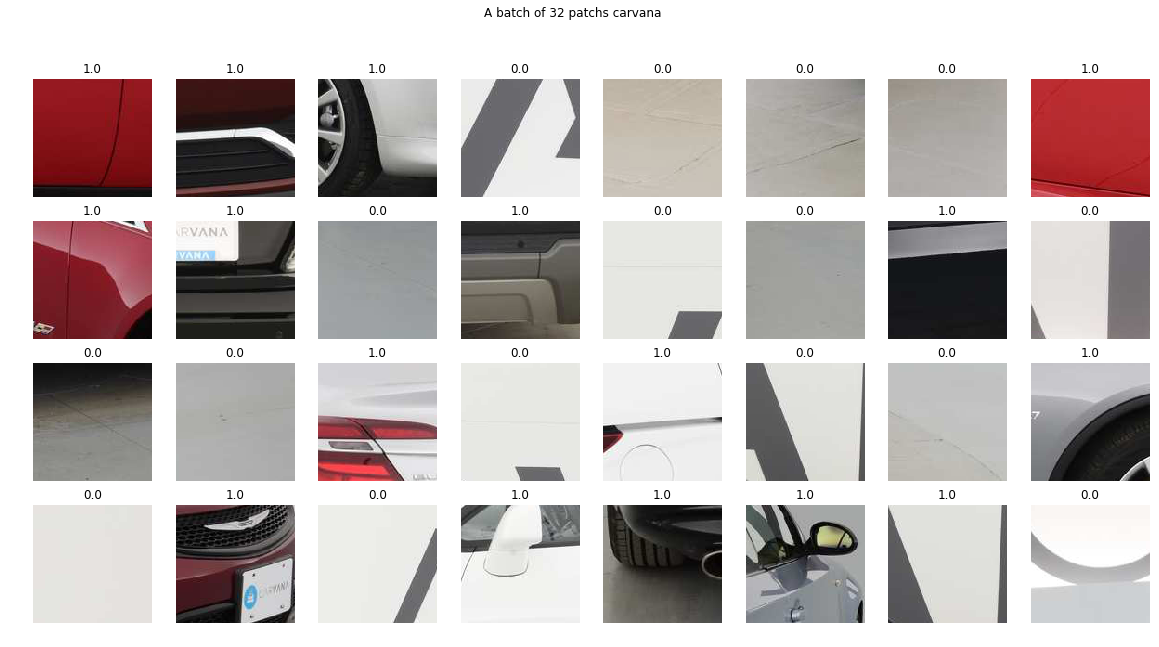

In [26]:
%matplotlib inline
f, axes = plt.subplots(4, 8, figsize=(20,10));
ax = axes.flatten();
for i in range(example_X.shape[0]):
    _ = ax[i].imshow(example_X[i]);
    _ = ax[i].set_title(example_y[i][0])
    _ = ax[i].axis('off');
f.suptitle('A batch of 32 patchs carvana');

搭建深度学习网络模型

In [5]:
from keras.models import Sequential
from keras.layers import Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(128,128,3)))
model.add(Convolution2D(100, (3, 3), strides=(2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(200, (3, 3), strides=(2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(300, (3, 3), activation='relu', padding='same'))
model.add(Convolution2D(300, (3, 3), activation='relu', padding='same'))

model.add(Dropout(0.1))
model.add(Convolution2D(2, (1, 1)))
# model.add(Conv2DTranspose(2, (31, 31), strides=(16,16), activation='softmax', padding='same'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
from keras.models import Model, load_model
from keras.layers import Dense, Lambda, Dropout, GlobalAveragePooling2D
from keras.callbacks import CSVLogger
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.optimizers import SGD

widths, heights = 150, 150
FC_SIZE = 1024
classes = 2

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(widths, heights, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(FC_SIZE, activation='relu')(x)  # new FC layer, random init
predictions = Dense(classes, activation='softmax')(x)  # new softmax layer
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = True
model.compile(optimizer=SGD(lr=0.001, momentum=0.9, decay=0.5), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 150, 150, 3)   0                                            
____________________________________________________________________________________________________
conv2d_95 (Conv2D)               (None, 74, 74, 32)    864         input_2[0][0]                    
____________________________________________________________________________________________________
batch_normalization_95 (BatchNor (None, 74, 74, 32)    96          conv2d_95[0][0]                  
____________________________________________________________________________________________________
activation_95 (Activation)       (None, 74, 74, 32)    0           batch_normalization_95[0][0]     
___________________________________________________________________________________________

In [7]:
from datetime import datetime
from keras.callbacks import CSVLogger

epochs = 30
batch_size = 16

start_time = datetime.now()
csvlogger = CSVLogger('train_30_8_100.log', append=True)

model.fit_generator(data_generator(train_set, batch_size=batch_size, widths=150, heights=150),
                    steps_per_epoch=100,
                    epochs=epochs,
                    validation_data=data_generator(valid_set, batch_size=batch_size, widths=150, heights=150),
                    validation_steps=50,
                    verbose=1,
                    workers=100,
                    callbacks=[csvlogger])
model.save('model_30_8_100.h5')
end_time = datetime.now()
print('Model Training Time:%.1f minutes'%((end_time-start_time).seconds / 60,))

Epoch 1/30
100/100 [==============================] - 422s - loss: 0.5096 - acc: 0.7525 - val_loss: 0.7177 - val_acc: 0.6687
Epoch 2/30
100/100 [==============================] - 303s - loss: 0.4539 - acc: 0.8194 - val_loss: 0.4210 - val_acc: 0.8488
Epoch 3/30
100/100 [==============================] - 303s - loss: 0.4342 - acc: 0.8469 - val_loss: 0.3993 - val_acc: 0.8700
Epoch 4/30
100/100 [==============================] - 303s - loss: 0.4080 - acc: 0.8619 - val_loss: 0.4084 - val_acc: 0.8425
Epoch 5/30
100/100 [==============================] - 302s - loss: 0.4233 - acc: 0.8488 - val_loss: 0.3862 - val_acc: 0.8850
Epoch 6/30
100/100 [==============================] - 301s - loss: 0.4253 - acc: 0.8400 - val_loss: 0.3862 - val_acc: 0.8762
Epoch 7/30
100/100 [==============================] - 304s - loss: 0.4132 - acc: 0.8612 - val_loss: 0.3838 - val_acc: 0.8662
Epoch 8/30
100/100 [==============================] - 301s - loss: 0.3979 - acc: 0.8694 - val_loss: 0.3688 - val_acc: 0.8850


In [6]:
from datetime import datetime
from keras.callbacks import CSVLogger
from keras.models import Model, load_model
from keras.optimizers import SGD

epochs = 30
batch_size = 8
widths, heights = 150, 150

start_time = datetime.now()
model = load_model('model_30_8_100.h5')
# model.compile(optimizer=SGD(lr=0.0001, momentum=0.9, decay=0.5), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

csvlogger = CSVLogger('train_30_8_100_02.log', append=True)

model.fit_generator(data_generator(train_set, batch_size=batch_size, widths=150, heights=150),
                    steps_per_epoch=200,
                    epochs=epochs,
                    validation_data=data_generator(valid_set, batch_size=batch_size, widths=150, heights=150),
                    validation_steps=100,
                    verbose=1,
                    workers=200,
                    callbacks=[csvlogger])
model.save('model_30_8_100_02.h5')
end_time = datetime.now()
print('Model Training Time:%.1f minutes'%((end_time-start_time).seconds / 60,))

Epoch 1/30
200/200 [==============================] - 427s - loss: 0.4130 - acc: 0.8450 - val_loss: 0.3267 - val_acc: 0.8825
Epoch 2/30
200/200 [==============================] - 307s - loss: 0.3982 - acc: 0.8469 - val_loss: 0.3061 - val_acc: 0.8988
Epoch 3/30
200/200 [==============================] - 311s - loss: 0.3840 - acc: 0.8556 - val_loss: 0.2809 - val_acc: 0.9087
Epoch 4/30
200/200 [==============================] - 314s - loss: 0.3689 - acc: 0.8488 - val_loss: 0.2820 - val_acc: 0.9087
Epoch 5/30
200/200 [==============================] - 313s - loss: 0.3742 - acc: 0.8544 - val_loss: 0.3000 - val_acc: 0.9000
Epoch 6/30
200/200 [==============================] - 311s - loss: 0.3456 - acc: 0.8788 - val_loss: 0.2586 - val_acc: 0.9187
Epoch 7/30
200/200 [==============================] - 313s - loss: 0.3665 - acc: 0.8525 - val_loss: 0.2396 - val_acc: 0.9337
Epoch 8/30
200/200 [==============================] - 323s - loss: 0.3625 - acc: 0.8481 - val_loss: 0.2454 - val_acc: 0.9137


In [6]:
from datetime import datetime
from keras.callbacks import CSVLogger
from keras.models import Model, load_model
from keras.optimizers import SGD

epochs = 80
batch_size = 8
widths, heights = 150, 150

start_time = datetime.now()
model = load_model('model_30_8_100_02.h5')
# model.compile(optimizer=SGD(lr=0.0001, momentum=0.9, decay=0.5), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

csvlogger = CSVLogger('train_30_8_100_03.log', append=True)

model.fit_generator(data_generator(train_set, batch_size=batch_size, widths=150, heights=150),
                    steps_per_epoch=200,
                    epochs=epochs,
                    validation_data=data_generator(valid_set, batch_size=batch_size, widths=150, heights=150),
                    validation_steps=100,
                    verbose=1,
                    workers=200,
                    callbacks=[csvlogger])
model.save('model_30_8_100_03.h5')
end_time = datetime.now()
print('Model Training Time:%.1f minutes'%((end_time-start_time).seconds / 60,))

Epoch 1/80
200/200 [==============================] - 447s - loss: 0.2856 - acc: 0.8844 - val_loss: 0.2220 - val_acc: 0.9163
Epoch 2/80
200/200 [==============================] - 307s - loss: 0.2933 - acc: 0.8887 - val_loss: 0.1773 - val_acc: 0.9413
Epoch 3/80
200/200 [==============================] - 306s - loss: 0.2715 - acc: 0.8894 - val_loss: 0.1822 - val_acc: 0.9313
Epoch 4/80
200/200 [==============================] - 316s - loss: 0.2611 - acc: 0.9006 - val_loss: 0.1666 - val_acc: 0.9413
Epoch 5/80
200/200 [==============================] - 318s - loss: 0.2714 - acc: 0.8913 - val_loss: 0.1740 - val_acc: 0.9363
Epoch 6/80
200/200 [==============================] - 315s - loss: 0.2503 - acc: 0.9031 - val_loss: 0.1850 - val_acc: 0.9287
Epoch 7/80
200/200 [==============================] - 313s - loss: 0.2668 - acc: 0.9031 - val_loss: 0.1955 - val_acc: 0.9225
Epoch 8/80
200/200 [==============================] - 313s - loss: 0.2536 - acc: 0.9050 - val_loss: 0.1926 - val_acc: 0.9275


200/200 [==============================] - 311s - loss: 0.2081 - acc: 0.9231 - val_loss: 0.1497 - val_acc: 0.9500
Epoch 66/80
200/200 [==============================] - 313s - loss: 0.2037 - acc: 0.9263 - val_loss: 0.1234 - val_acc: 0.9550
Epoch 67/80
200/200 [==============================] - 322s - loss: 0.2440 - acc: 0.9150 - val_loss: 0.1265 - val_acc: 0.9563
Epoch 68/80
200/200 [==============================] - 329s - loss: 0.1878 - acc: 0.9344 - val_loss: 0.1335 - val_acc: 0.9550
Epoch 69/80
200/200 [==============================] - 317s - loss: 0.2360 - acc: 0.9150 - val_loss: 0.1212 - val_acc: 0.9537
Epoch 70/80
200/200 [==============================] - 315s - loss: 0.2011 - acc: 0.9306 - val_loss: 0.1485 - val_acc: 0.9487
Epoch 71/80
200/200 [==============================] - 317s - loss: 0.1976 - acc: 0.9356 - val_loss: 0.1482 - val_acc: 0.9500
Epoch 72/80
200/200 [==============================] - 319s - loss: 0.1980 - acc: 0.9300 - val_loss: 0.1537 - val_acc: 0.9475
Epoc

In [ ]:
from datetime import datetime
from keras.callbacks import CSVLogger
from keras.models import Model, load_model
from keras.optimizers import SGD

epochs = 80
batch_size = 8
widths, heights = 150, 150

start_time = datetime.now()
model = load_model('model_30_8_100_02.h5')
# model.compile(optimizer=SGD(lr=0.0001, momentum=0.9, decay=0.5), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

csvlogger = CSVLogger('train_30_8_100_03.log', append=True)

model.fit_generator(data_generator(train_set, batch_size=batch_size, widths=150, heights=150),
                    steps_per_epoch=200,
                    epochs=epochs,
                    validation_data=data_generator(valid_set, batch_size=batch_size, widths=150, heights=150),
                    validation_steps=100,
                    verbose=1,
                    workers=200,
                    callbacks=[csvlogger])
model.save('model_30_8_100_03.h5')
end_time = datetime.now()
print('Model Training Time:%.1f minutes'%((end_time-start_time).seconds / 60,))

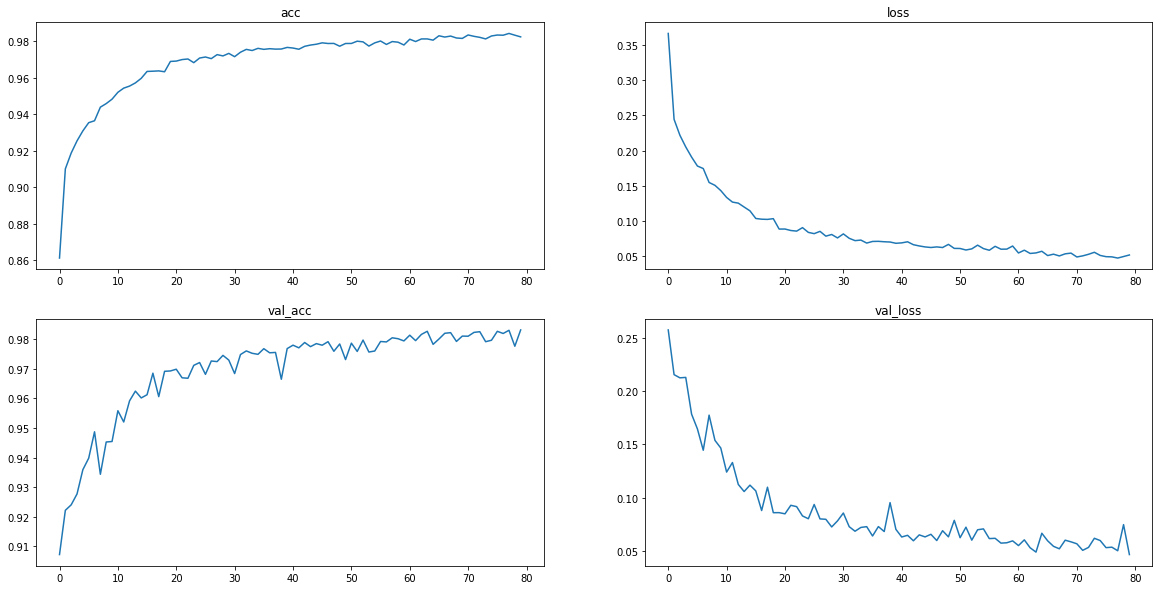

In [9]:
# 自定义网络层训练效果
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


train_log = open("train_64_200.log")
log_line = train_log.readlines()
# log_line
epoch = []
acc = []
loss = []
val_acc = []
val_loss = []

for i in range(len(log_line)):
    if i<len(log_line)-1:
        line_list = list(eval(log_line[i+1]))
        epoch.append(line_list[0])
        acc.append(line_list[1])
        loss.append(line_list[2])
        val_acc.append(line_list[3])
        val_loss.append(line_list[4])

fig, axes = plt.subplots(2,2,figsize=(20,10))    # 自定义每个小图的尺寸
ax = axes.ravel()
ax[0].plot(epoch,acc)
ax[0].set_title('acc')

ax[1].plot(epoch,loss)
ax[1].set_title('loss')
ax[2].plot(epoch,val_acc)
ax[2].set_title('val_acc')
ax[3].plot(epoch,val_loss)
ax[3].set_title('val_loss')

In [10]:
def predict_from_model(patch, model):
    
    prediction = model.predict(patch.reshape(1, 128, 128, 3))
    prediction = prediction[:, :, :, 1].reshape(128, 128)
    return prediction

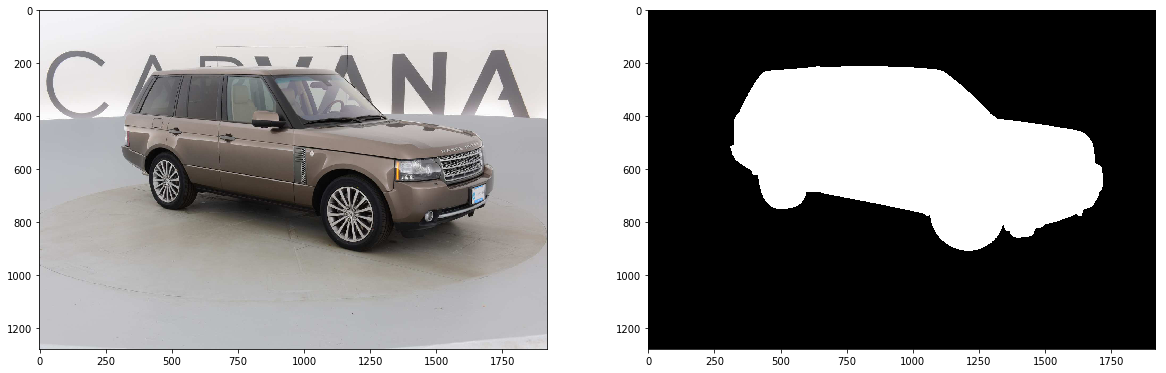

In [11]:
%matplotlib inline
from PIL import Image

random_choice = np.random.choice(test_set)    # 从给定的数据集中随机选取一张
random_choice_path = join(base_path, "train/" + random_choice)    # 获得该随机图片的路径
random_mask_path = join(base_path, "train_masks/" + (random_choice.split("."))[0] + "_mask.gif")    # 获得该随机图片对应的mask

car_pic = Image.open(random_choice_path)    # 读取该随机图片
mask_pic = Image.open(random_mask_path)    # 读取该随机图片对应的mask

f, axes = plt.subplots(1,2,figsize=(20,20))
ax = axes.ravel()
ax[0].imshow(car_pic)
ax[1].imshow(mask_pic)

np.append
np.hstack,np.vstack
np.concatenate
np.column_stack()
np.delete()

In [21]:
from keras.models import load_model



model = load_model('./model_64_200.h5')

widths, heights = 128, 128

pat_pred = np.zeros((128, 1920))

if (car_pic.size[0]-(car_pic.size[0]//128)*128) !=0:
    r

for i in range(car_pic.size[1]//heights):
    pat_pre = np.zeros((128,128))
    
    for j in range(car_pic.size[0]//widths):
        pat = (Image.open(random_choice_path)).crop((j*widths,i*widths,(j+1)*widths,(i+1)*heights))
        pat_array = np.array(pat)
        pre_pat = predict_from_model(pat_array, model)
        
#         pat_set[i] = np.concatenate([pat_set[i], pat_array])
        pat_pre = np.hstack((pat_pre, pre_pat))
        
    pat_pred = np.vstack((pat_pred, pat_pre))
#         _= ax[j].imshow(patch)
# (np.array(pat_set)).shape
(np.array(pat_pred)).shape

(1408, 1920)

(1280, 1918)


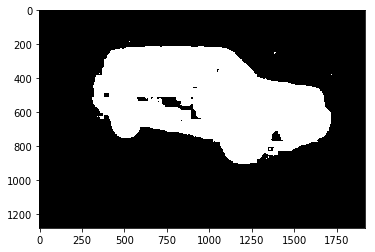

In [35]:
# from keras.preprocessing import image
import matplotlib.pyplot as plt

predic01 = np.array(pat_pred)
for i in range(128):
    predic01 = np.delete(predic01,i,1)
    predic01 = np.delete(predic01,i,0)

predic02 = np.column_stack((predic01,(np.zeros((1280,126))).astype(int)))    
print(predic02.shape)

# img03 = patch_pre[56].reshape(128, 128)
# img03.shape
# img04 = image.array_to_img(img03)
plt.imshow((predic02>0.5).astype(np.int),cmap='gray',vmin=0,vmax=1)
plt.show()
